# Train

In [14]:
%run keras_retinanet/bin/train.py --batch-size 1 --epochs 1 --steps 50 coco dataset/coco

Creating generators, this may take a second...
loading annotations into memory...
Done (t=15.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Creating model, this may take a second...


/Users/luke/Documents/dev/github/fingerplus/edwin-jarvis/keras-retinanet/keras_retinanet/bin/train.py:89: UserWarning: Output "concatenate_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "concatenate_12" during training.
  optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)


Creating callback
training
Epoch 1/1
50/50 [==============================] - 639s 13s/step - loss: 4.5166 - regression_loss: 1.1657 - classification_loss: 3.3508


OSError: Unable to create file (unable to open file: name = './snapshots', errno = 21, error message = 'Is a directory', flags = 13, o_flags = 602)

# Predict

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/luke/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# model = keras.models.load_model('/Users/luke/Documents/ml_models/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
mymodel = keras.models.load_model('/Users/luke/Documents/ml_models/videotag/resnet50_coco_epoch_40_loss_0.04253.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


In [3]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CocoGenerator(
    '/Users/luke/Documents/ml_datasets/new/videotag',
    'val2017',
    transform_generator=val_image_data_generator,
    batch_size=1,
)
index = 0

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


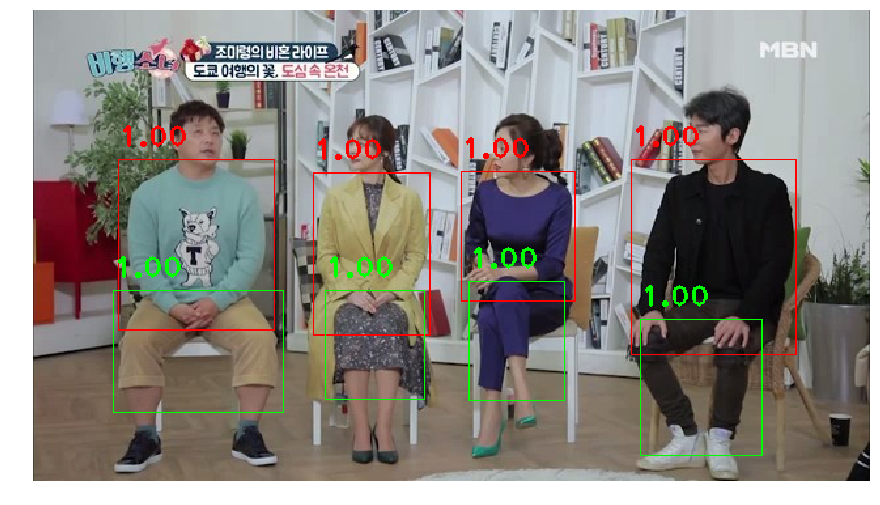

In [48]:
# load image
image = val_generator.load_image(index)
# print(image.shape)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)

# print(image.shape, scale)
annotations = val_generator.load_annotations(index)
# index += 1

# process image
start = time.time()
_, _, detections = mymodel.predict_on_batch(np.expand_dims(image, axis=0))
# print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.9:
        continue
    b = detections[0, idx, :4].astype(int)
    color = (255,0,0)
    if label == 1 or label == '1':
        color = (0,255,0)
        
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), color, 1)
    caption = "{:.2f}".format(score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, color, 2)
    
# visualize annotations
# for annotation in annotations:
#     label = int(annotation[4])
#     b = annotation[:4].astype(int)
#     cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
#     caption = "{}".format(val_generator.label_to_name(label))
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

index += 1
